# IMPORTS

In [1]:
!pip install scikit_posthocs
!pip install plotly
!pip install pingouin
!pip install transformers

     |████████████████████████████████| 43 kB 640 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37902 sha256=2e598564857ad7e7d67c8938eee4c925ee0f105431c54e1674bdb6ad92d2da77
  Stored in directory: /root/.cache/pip/wheels/b8/21/e6/f39794d4a6ee3d3cc5146ca80b5cd949452ad4a8fde9f6b9fc
Successfully built scikit-posthocs
     |████████████████████████████████| 206 kB 5.3 MB/s 
     |████████████████████████████████| 28.5 MB 41 kB/s 
     |████████████████████████████████| 9.5 MB 35.2 MB/s 
  Created wheel for pingouin: filename=pingouin-0.4.0-py3-none-any.whl size=206904 sha256=34e2c5c5f77fa94daffe4fd24e4cdf5fbefd7e46d4e278e70df87f7aa8d04cf0
  Stored in directory: /root/.cache/pip/wheels/8a/9d/c4/11677c2c4d5c0df9d1d4aa61528d868bb96e13b898e3f51c95
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.w

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import pingouin as pg
from sklearn import preprocessing
import scikit_posthocs as sp
from scipy.stats import pearsonr, spearmanr
from google.colab import files
import math
import scipy
from sklearn.metrics import r2_score
import plotly.express as px
import plotly.figure_factory as ff
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import nltk

nltk.download('punkt')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# CORRELATION

In [3]:
#Calculates correlation between two single arrays
def calculate_correlation(data1, data2, variable1, variable2, corr_type, print_or_not):
    data1= np.array(data1[variable1])
    data2= np.array(data2[variable2])
    alpha = 0.05
    corr = 0
    p = 0
    if corr_type == 'Pearson':
      # calculate Pearson's correlation
      corr, p = stats.pearsonr(data1, data2)
      corr_type = 'Pearson'
    elif corr_type == "Spearman":
      # calculate spearman's correlation
      corr, p = stats.spearmanr(data1, data2)
      corr_type='Spearman'
    else:
      corr, p = stats.spearmanr(data1, data2)
    if print_or_not == True:
      print('')
      print('-----------Correlation between ', variable1, ' and ', variable2, '-----------')
      if p <= alpha:
        print('Significant correlation: %.3f' % p)
        print(corr_type + ' correlation: %.3f' % corr)
      else:
        print('NOT Significant correlation: %.3f' % p)
        print(corr_type + ' correlation: %.3f' % corr)
    return corr_type, corr, p

In [4]:
def calculate_correlation_pearson_or_spearman(data1, data2, variable1, variable2, print_or_not, corr_type):
    data1= np.array(data1[variable1])
    data2= np.array(data2[variable2])
    alpha = 0.05
    corr = 0
    p = 0
    # calculate Pearson's correlation
    if corr_type == "Pearson":
      corr, p = stats.pearsonr(data1, data2)
    elif corr_type == "Spearman":
      corr, p = stats.spearmanr(data1, data2)
    else:
      print("Wrong Correlation type")
      return None
    if print_or_not == True:
        print('')
        print('-----------Correlation between ', variable1, ' and ', variable2, '-----------')
        print(normal1, normal2)
        if p <= alpha:
          print('Significant correlation: %.3f' % p)
          print(corr_type + ' correlation: %.3f' % corr)
        else:
          print('NOT Significant correlation: %.3f' % p)
          print(corr_type + ' correlation: %.3f' % corr)
    return corr_type, corr, p

In [5]:
# calculates correlation between an array and a dataframe for the given columns
def calculate_correlation_multiple(data1, data2, variable1, my_columns, corr_type, col_names):
    var1 = list()
    corr_t = list()
    corrl=list()
    signif=list()
    for i in range(len(my_columns)):
        corr_type, corr, p = calculate_correlation(data1, data2, variable1, my_columns[i], corr_type, False)
        var1.append(my_columns[i])
        corr_t.append(corr_type)
        corrl.append(round(corr, 3))
        signif.append(round(p, 3))
    corr_table = pd.DataFrame([var1, corr_t, corrl, signif]).transpose()
    var2 = pd.Series([variable1]*len(my_columns))
    corr_table = pd.concat([var2, corr_table], axis = 1)
    corr_table.columns = col_names
    #print(corr_table)
    return corr_table

In [6]:
#calculates correlation table between two dataframes for the given columns
def create_correlation_table(data1, data2, my_columns1, my_columns2, corr_type, col_names):
    df = pd.DataFrame()
    for i in range(len(my_columns1)):
        df_new = calculate_correlation_multiple(data1, data2, my_columns1[i], my_columns2, corr_type, col_names)
        df = pd.concat([df, df_new], axis = 0)
    return df

In [7]:
def get_confidence_interval(corr, nr_items):
  stderr = 1.0 / math.sqrt(nr_items - 3)
  delta = 1.96 * stderr
  lower = math.tanh(math.atanh(corr) - delta)
  lower = round(lower, 3)
  upper = math.tanh(math.atanh(corr) + delta)
  upper = round(upper, 3)
  return lower, upper

# T-TEST, ANOVA

In [8]:
def check_normal(data, column, something):
    w, p = stats.shapiro(data[column])
    #print(p)
    alpha = 0.05
    normal = False
    if p > alpha:
        normal = True
    return normal

In [9]:
# test for homogenity of variances for dataframes
def check_homogenity_of_variances_levene(data1, data2, variable1, variable2):
    df1 = np.array(data1[variable1].dropna())
    df2 = np.array(data2[variable2].dropna())
    stat, p = stats.levene(df1, df2)
    alpha = 0.05
    homogen = False
    if p > alpha:
        #print('Homogeneity of variances')
        homogen = True
    #else:
        #print('NO Homogeneity of variances')
    return homogen


def check_homogenity_of_variances_levene_df(data, columns):
     df = list()
     for i in range(len(columns)):
         df1 = list((data[columns[i]].dropna()).values)
         df.append(df1)
     stat, p = stats.levene(*df)
     homogen = False
     if p > 0.05:
        #print('Homogeneity of variances')
        homogen = True
    #else:
        #print('NO Homogeneity of variances')
     return homogen

In [10]:
def independent_t_test(data1, data2, variable1, variable2):
    normal1 = check_normal(data1, variable1, 'soft')
    normal2 = check_normal(data2, variable2, 'soft') 
    df1 = np.array(data1[variable1].dropna())
    df2 = np.array(data2[variable2].dropna())
    difference =  False
    if normal1 == True and normal2 == True:
        homogen = check_homogenity_of_variances_levene(data1, data2, variable1, variable2)
        if homogen == True:
            stat, p = stats.ttest_ind(df1, df2, equal_var = True)
            print('INDEPENDENT T-TEST: t=%.3f, p=%.3f' % (stat, p))
            if p > 0.05:
                print('NO significant difference between ', variable1, ' and ', variable2)
            else:
                print('Significant difference between ', variable1, ' and ', variable2)
                difference = True
        else:
            stat, p = stats.ttest_ind(df1, df2, equal_var = False)
            print('t=%.3f, p=%.3f' % (stat, p))
            if p > 0.05:
                print('NO significant difference between ', variable1, ' and ', variable2)
            else:
                print('Significant difference between ', variable1, ' and ', variable2)
                difference = True
        if difference == True:
            mean_gr1 = df1.mean()
            mean_gr2 = df2.mean()
            sd_gr1 = df1.std()
            sd_gr2 = df2.std()
            print('Mean of ' + variable1 + ' is: ' + str(mean_gr1) + ' and sd is: ' + str(sd_gr1))
            print('Mean of ' + variable2 + ' is: ' + str(mean_gr2) + ' and sd is: ' + str(sd_gr2))
        return stat, p, difference
    else:
        print('One of the distributions is not normal, please use mann-whitney test')
        mann_whitney(data1, data2, variable1, variable2)

In [11]:
def mann_whitney(data1, data2, variable1, variable2):
  normal1 = check_normal(data1, variable1, 'soft')
  normal2 = check_normal(data2, variable2, 'soft') 
  df1 = np.array(data1[variable1].dropna())
  df2 = np.array(data2[variable2].dropna())
  stat, p = stats.mannwhitneyu(df1, df2)
  print('')
  print('MANN-WHITNEY U TEST: Statistics=%.3f, p=%.3f' % (stat, p))
  difference = False
  if p > 0.05:
    print('NO significant difference between ' + variable1 + " and " + variable2)
    mean_gr1 = df1.mean()
    mean_gr2 = df2.mean()
    print('Mean of ' + variable1 + ' is: ' + str(mean_gr1))
    print('Mean of ' + variable2 + ' is: ' + str(mean_gr2))
  else:
    print('Significant difference between ' + variable1 + " and " + variable2)
    difference = True
    mean_gr1 = df1.mean()
    mean_gr2 = df2.mean()
    print('Mean of ' + variable1 + ' is: ' + str(mean_gr1) )
    print('Mean of ' + variable2 + ' is: ' + str(mean_gr2) )
  return stat, p, difference

In [12]:
def one_way_anova(data, columns):
  normal_list = list()
  length = len(columns)
  for i in range(length):
      normal1 = check_normal(data, columns[i], 'soft')
      normal_list.append(normal1)
  if all(normal_list) == True:
    homogen = check_homogenity_of_variances_levene_df(data, columns)
    
    if homogen == True:
      difference=False
      df = list()
      for i in range(len(columns)):
        k = data[columns[i]].dropna()
        df1 = list(k.values)
        df.append(df1) 
      stat, p = stats.f_oneway(*df)
      print('ONE WAY INDEPENDENT ANOVA: Statistics=%.5f, p=%.5f' % (stat, p))
      if p > 0.05:
        print('NO significant difference between:')
        print(columns)
        return stat, p, difference
      else:
        print('Significant difference between:')
        print(columns)
        print('')
        difference = True
        mean_list = list()
        sd_list = list()
        for i in range(len(df)):
          mean_gr = round((np.array(df[i]).mean()), 3)
          sd_gr = round((np.array(df[i]).std()), 3)
          print('Mean of ' + columns[i] + ' is: ' + str(mean_gr) + ' and sd is: ' + str(sd_gr))
          mean_list.append(mean_gr)
          sd_list.append(sd_gr)
        new_df = pd.concat([pd.Series(columns), pd.Series(mean_list), pd.Series(sd_list)], axis=1)
        new_df.columns = ['Factor', 'Mean', 'SD']
        return stat, p, difference, new_df
    else:
      print('The Variances of populations are NOT equal. Please use Kruskall-Wallis')
      return None
  else:
    print('Not all distributions are normal, please use Kruskall-Wallis')
    return None

In [13]:
def one_way_r_anova(data, columns):
  normal_list = list()
  length = len(columns)
  for i in range(length):
      normal1 = check_normal(data, columns[i], 'soft')
      normal_list.append(normal1)
  if all(normal_list) == True:
    homogen = check_homogenity_of_variances_levene_df(data, columns)
    
    if homogen == True:
      difference=False
      df = list()
      for i in range(len(columns)):
        k = data[columns[i]].dropna()
        df1 = list(k.values)
        df.append(df1) 
      df_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars=columns)
      df_melt.columns = ['index', 'summarization_methods', 'scores']
      anova_df = pg.rm_anova(dv='scores', within='summarization_methods', subject='index', data=df_melt)
      stat, p = anova_df.iloc[0]['F'], anova_df.iloc[0]['p-unc']
      print('ONE WAY REPEATED ANOVA: Statistics=%.5f, p=%.5f' % (stat, p))
      if p > 0.05:
        print('NO significant difference between:')
        print(columns)
        return stat, p, difference
      else:
        print('Significant difference between:')
        print(columns)
        print('')
        difference = True
        mean_list = list()
        sd_list = list()
        for i in range(len(df)):
          mean_gr = round((np.array(df[i]).mean()), 3)
          sd_gr = round((np.array(df[i]).std()), 3)
          print('Mean of ' + columns[i] + ' is: ' + str(mean_gr) + ' and sd is: ' + str(sd_gr))
          mean_list.append(mean_gr)
          sd_list.append(sd_gr)
        new_df = pd.concat([pd.Series(columns), pd.Series(mean_list), pd.Series(sd_list)], axis=1)
        new_df.columns = ['Factor', 'Mean', 'SD']
        return stat, p, difference, new_df
    else:
      print('The Variances of populations are NOT equal. Please use Friedmans test')
      return None
  else:
    print('Not all distributions are normal, please use Friedmans test')
    return None

In [14]:
def kruskal_wallis(data, columns):
  normal_list = list()
  length = len(columns)
  for i in range(length):
    normal1 = check_normal(data, columns[i], 'soft')
    normal_list.append(normal1)
  homogen = check_homogenity_of_variances_levene_df(data, columns)
  if all(normal_list) == True and homogen == True:  
    print('Please use independent t-Test or anova, both features are normal distributed.')
    return None
  else:
    difference=False
    df = list()
    for i in range(len(columns)):
      k = data[columns[i]].dropna()
      df1 = list(k.values)
      df.append(df1)  
    stat, p = stats.kruskal(*df)
    print('KRUSKAL-WALLIS-H TEST: Statistics=%.5f, p=%.5f' % (stat, p))
    if p > 0.05:
      print('NO significant difference between:')
      print(columns)
      return stat, p, difference
    else:
      print('Significant difference between:')
      print(columns)
      print('')
      difference = True
      mean_list = list()
      sd_list = list()
      for i in range(len(df)):
        mean_gr = round((np.array(df[i]).mean()), 3)
        sd_gr = round((np.array(df[i]).std()), 3)
        print('Mean of ' + columns[i] + ' is: ' + str(mean_gr) + ' and sd is: ' + str(sd_gr))
        mean_list.append(mean_gr)
        sd_list.append(sd_gr)
      new_df = pd.concat([pd.Series(columns), pd.Series(mean_list), pd.Series(sd_list)], axis=1)
      new_df.columns = ['Factor', 'Mean', 'SD']
      return stat, p, difference, new_df

In [15]:
def friedman(data, columns):
  normal_list = list()
  length = len(columns)
  for i in range(length):
    normal1 = check_normal(data, columns[i], 'soft')
    normal_list.append(normal1)
  homogen = check_homogenity_of_variances_levene_df(data, columns)
  if all(normal_list) == True and homogen == True:  
    print('Please use repeated t-Test or anova, both features are normal distributed.')
    return None
  else:
    difference=False
    df = list()
    for i in range(len(columns)):
      k = data[columns[i]].dropna()
      df1 = list(k.values)
      df.append(df1)  
    stat, p = stats.friedmanchisquare(*df)
    print('FRIEDMAN TEST: Statistics=%f, p=%f' % (stat, p))
    if p > 0.05:
      print('NO significant difference between:')
      print(columns)
      return stat, p, difference
    else:
      print('Significant difference between:')
      print(columns)
      print('')
      difference = True
      mean_list = list()
      sd_list = list()
      for i in range(len(df)):
        mean_gr = round((np.array(df[i]).mean()), 3)
        sd_gr = round((np.array(df[i]).std()), 3)
        print('Mean of ' + columns[i] + ' is: ' + str(mean_gr) + ' and sd is: ' + str(sd_gr))
        mean_list.append(mean_gr)
        sd_list.append(sd_gr)
      new_df = pd.concat([pd.Series(columns), pd.Series(mean_list), pd.Series(sd_list)], axis=1)
      new_df.columns = ['Factor', 'Mean', 'SD']
      return stat, p, difference, new_df

In [16]:
def convert_df(data, columns):
    rows, columns1 = data.shape
    new_rows = rows * len(columns)
    df = list()
    for i in range(len(columns)):
        new_df = pd.Series((data[columns[i]].values))
        df.append(new_df)
    #print(df)
    groups = list()
    for i in range(len(columns)):
        for k in range(rows):
            groups.append(columns[i])
    final_df = pd.concat(df, axis = 0)
    final_df.index = list(np.arange(0, new_rows, 1))
    #print(final_df)
    final_df = pd.concat([final_df, pd.Series(groups)], axis=1)
    final_df.columns = ['Variable', 'Groups']
    return final_df

In [17]:
# post hoc test after independetn anova: Tukey’s honestly significantly differenced (HSD) test
        
def posthoc_test_tukey(data, columns):
  df = convert_df(data, columns)
  result = sp.posthoc_tukey(df, val_col='Variable', group_col='Groups', sort = False)
  # Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
  cmap = ['1', 'Lightgrey',  '#08306b',  '#4292c6', '#c6dbef']
  heatmap_args = {'cmap': cmap, 'linewidths': 0.1, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
  sp.sign_plot(result, **heatmap_args)
  plt.show()
  return result

In [18]:
# post hoc test after repeated anova: T test with Benjamini/Hochberg FDR correction
        
def posthoc_ttest(data, columns):
  df = convert_df(data, columns)
  result = sp.posthoc_ttest(df, val_col='Variable', group_col='Groups', p_adjust='fdr_bh', sort = False)
  # Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
  cmap = ['1', 'Lightgrey',  '#08306b',  '#4292c6', '#c6dbef']
  heatmap_args = {'cmap': cmap, 'linewidths': 0.1, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
  sp.sign_plot(result, **heatmap_args)
  plt.show()
  return result

In [19]:
# post hoc test after independent kruskall wallis: Dunn`s test

def posthoc_dunn(data, columns):
  df = convert_df(data, columns)
  #plt.figure(figsize=(8,8))
  result = sp.posthoc_dunn(df, val_col = 'Variable', group_col='Groups', sort=False)
  # Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
  cmap = ['1', 'Lightgrey',  '#08306b',  '#4292c6', '#c6dbef']
  heatmap_args = {'cmap': cmap, 'linewidths': 0.1, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
  sp.sign_plot(result, **heatmap_args)
  plt.show()
  return result

In [20]:
# post hoc test after repeated Friedman's test: Nemenyi's test
        
def posthoc_nemenyi_friedman(data, columns):
  result = sp.posthoc_nemenyi_friedman(data.values.tolist(), sort = False)
  result.columns = columns

  # Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
  cmap = ['1', 'Lightgrey',  '#08306b',  '#4292c6', '#c6dbef']
  heatmap_args = {'cmap': cmap, 'linewidths': 0.1, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
  sp.sign_plot(result, **heatmap_args)
  plt.show()
  return result

# Quality Estimation

In [21]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-german-cased')
MAX_LEN = 200

def get_text_with_breaks(reference: str, language='german') -> str:
    sentences = nltk.sent_tokenize(reference, language)

    return "\n".join(sentences)

def get_qe(hypothesis, avg=True):
    output = {
        'expert_coherence': [],
        'expert_fluency': [],
        'expert_relevance': [],
        'expert_consistency': [],
        'crowd_coherence': [],
        'crowd_fluency': [],
        'crowd_relevance': [],
        'crowd_consistency': [],
        }

    for key, value in output.items():
        # Model class must be defined somewhere
        model = torch.load(f'models/cnndm/{key}.pt')
        model.eval()

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []

        # For every sentence...
        for sent in hypothesis:
            # `encode` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            encoded_sent = tokenizer.encode(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        )
            
            input_ids.append(encoded_sent)

        # Pad our input tokens
        input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                                dtype="long", truncating="post", padding="post")

        # Create attention masks
        attention_masks = []

        # Create a mask of 1s for each token followed by 0s for padding
        for seq in input_ids:
            seq_mask = [float(i>0) for i in seq]
            attention_masks.append(seq_mask) 

        # Convert to tensors.
        prediction_inputs = torch.tensor(input_ids)
        prediction_masks = torch.tensor(attention_masks)

        # Set the batch size.  
        batch_size = 16  

        # Create the DataLoader.
        prediction_data = TensorDataset(prediction_inputs, prediction_masks)
        prediction_sampler = SequentialSampler(prediction_data)
        prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

        # Prediction on test set

        print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

        # Predict 
        for batch in prediction_dataloader:
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask = batch
            
            # Telling the model not to compute or store gradients, saving memory and 
            # speeding up prediction
            with torch.no_grad():
                # Forward pass, calculate logit predictions
                outputs = model(b_input_ids, token_type_ids=None, 
                                attention_mask=b_input_mask)

            logits = outputs[0]

            # Move logits to CPU
            logits = logits.detach().cpu().numpy()
            # Store predictions
            pred_labels_i = np.argmax(logits, axis=1).flatten()
            value.extend(pred_labels_i + 1)

    return output

There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Loading BERT tokenizer...


Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456 [00:00<?, ?B/s]

# LOAD DATA

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
cd /content/drive/My Drive/GeSumGenEval

/content/drive/.shortcut-targets-by-id/1PcWXs_So5sTaP0wBAR77_ORSfd4aFtHq/GeSumGenEval


## Machine Evaluation

In [24]:
def remove_outliers(df):
    z_scores = stats.zscore(df)

    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    new_df = df[filtered_entries]

    return new_df

In [25]:
dataset = "gewiki"
sample_size = 1000

mean_eval = pd.read_csv(f"results/{dataset}/eval.csv")
rouge1_eval = remove_outliers(pd.read_csv(f"results/{dataset}/rouge1_eval.csv").replace(0, np.nan).dropna()).sample(n=sample_size)
rouge2_eval = remove_outliers(pd.read_csv(f"results/{dataset}/rouge2_eval.csv").replace(0, np.nan).dropna()).sample(n=sample_size)
rougel_eval = remove_outliers(pd.read_csv(f"results/{dataset}/rougel_eval.csv").replace(0, np.nan).dropna()).sample(n=sample_size)
bleu_eval = remove_outliers(pd.read_csv(f"results/{dataset}/bleu_eval.csv").replace(0, np.nan).dropna()).sample(n=sample_size)
meteor_eval = remove_outliers(pd.read_csv(f"results/{dataset}/meteor_eval.csv").replace(0, np.nan).dropna()).sample(n=sample_size)
bert_score_eval = remove_outliers(pd.read_csv(f"results/{dataset}/bert_score_eval.csv").replace(0, np.nan).dropna()).sample(n=sample_size)
mover_score_eval = remove_outliers(pd.read_csv(f"results/{dataset}/mover_score_eval.csv").replace(0, np.nan).dropna()).sample(n=sample_size)
blanc_eval = remove_outliers(pd.read_csv(f"results/{dataset}/blanc_eval.csv").replace(0, np.nan).dropna()).sample(n=sample_size)
js_eval = remove_outliers(pd.read_csv(f"results/{dataset}/js_eval.csv").replace(0, np.nan).dropna()).sample(n=sample_size)
summarization_methods = ["Random-3", "Lead-3", "TextRank", "BertSum", "MatchSum", "Oracle"]
evaluation_methods = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "METEOR", "BERT-Score", "Mover-Score", "BLANC", "JS"]
merged_columns = ['summarization_method', 'evaluation_method', 'scores']

In [26]:
all_evals = pd.DataFrame(columns=merged_columns)
for eval_method in evaluation_methods:
    for summ_method in summarization_methods:
        scores_list = []
        if eval_method == "ROUGE-1":
            scores_list = rouge1_eval[summ_method]
        elif eval_method == "ROUGE-2":
            scores_list = rouge2_eval[summ_method]
        elif eval_method == "ROUGE-L":
            scores_list = rougel_eval[summ_method]
        elif eval_method == "BLEU":
            scores_list = bleu_eval[summ_method]
        elif eval_method == "METEOR":
            scores_list = meteor_eval[summ_method]
        elif eval_method == "BERT-Score":
            scores_list = bert_score_eval[summ_method]
        elif eval_method == "Mover-Score":
            scores_list = mover_score_eval[summ_method]
        elif eval_method == "BLANC":
            scores_list = blanc_eval[summ_method]
        elif eval_method == "JS":
            scores_list = js_eval[summ_method]

        #print(len(scores_list))
        temp_df = pd.DataFrame(
                        {
                            'summarization_method': [summ_method]*len(scores_list),
                            'evaluation_method': [eval_method]*len(scores_list),
                            'scores': scores_list
                        })
        all_evals = all_evals.append(temp_df)

print(all_evals.tail())

     summarization_method evaluation_method    scores
3895               Oracle                JS  0.376437
3190               Oracle                JS  0.467233
3017               Oracle                JS  0.399113
7614               Oracle                JS  0.372982
3533               Oracle                JS  0.424099


## Human Evaluation

In [27]:
mean_human_eval = pd.read_csv(f"results/mlsum/human_eval.csv")
ovq_eval = pd.read_csv(f"results/mlsum/ovq_eval.csv")
coherence_eval = pd.read_csv(f"results/mlsum/coherence_eval.csv")
readibility_eval = pd.read_csv(f"results/mlsum/readibility_eval.csv")
fluency_eval = pd.read_csv(f"results/mlsum/fluency_eval.csv")
inf_eval = pd.read_csv(f"results/mlsum/informativeness_eval.csv")
human_machine_eval = pd.read_csv(f"results/mlsum/human_machine_eval.csv")
human_summ_methods = ["TextRank", "BertSum", "MatchSum", "Expert"]
human_eval_methods = ["Overall Quality", "Coherence", "Readability", "Fluency", "Informativeness"]
qe_methods = ['expert_coherence', 'expert_fluency', 'expert_relevance', 'expert_consistency', 'crowd_coherence', 'crowd_fluency', 'crowd_relevance', 'crowd_consistency']
merged_columns = ['summarization_method', 'evaluation_method', 'scores']

In [28]:
all_human_evals = pd.DataFrame(columns=merged_columns)
for eval_method in human_eval_methods:
    for summ_method in human_summ_methods:
        scores_list = []
        if eval_method == "Overall Quality":
            scores_list = ovq_eval[summ_method]
        elif eval_method == "Coherence":
            scores_list = coherence_eval[summ_method]
        elif eval_method == "Readability":
            scores_list = readibility_eval[summ_method]
        elif eval_method == "Fluency":
            scores_list = fluency_eval[summ_method]
        elif eval_method == "Informativeness":
            scores_list = inf_eval[summ_method]
        #print(len(scores_list))
        temp_df = pd.DataFrame(
                        {
                            'summarization_method': [summ_method]*len(scores_list),
                            'evaluation_method': [eval_method]*len(scores_list),
                            'scores': scores_list
                        })
        all_human_evals = all_human_evals.append(temp_df)

print(all_human_evals.tail())

   summarization_method evaluation_method  scores
15               Expert   Informativeness     3.8
16               Expert   Informativeness     3.6
17               Expert   Informativeness     3.4
18               Expert   Informativeness     3.6
19               Expert   Informativeness     2.8


## Moving Machine Eval to Human Eval

In [29]:
def move_mac_eval_to_hum_eval():
    rouge1_eval = pd.read_csv(f"results/mlsum/rouge1_eval.csv")
    rouge2_eval = pd.read_csv(f"results/mlsum/rouge2_eval.csv")
    rougel_eval = pd.read_csv(f"results/mlsum/rougel_eval.csv")
    bleu_eval = pd.read_csv(f"results/mlsum/bleu_eval.csv")
    meteor_eval = pd.read_csv(f"results/mlsum/meteor_eval.csv")
    bert_score_eval = pd.read_csv(f"results/mlsum/bert_score_eval.csv")
    mover_score_eval = pd.read_csv(f"results/mlsum/mover_score_eval.csv")
    blanc_eval = pd.read_csv(f"results/mlsum/blanc_eval.csv")
    js_eval = pd.read_csv(f"results/mlsum/js_eval.csv")

    rouge1_list = []
    rouge2_list = [] 
    rougel_list = []
    bleu_list = []
    meteor_list = []
    bert_score_list = []
    mover_score_list = []
    blanc_list = []
    js_list = []
    summary_list = []
    for i in range(len(human_machine_eval)):
        index = human_machine_eval.iloc[i]["Source_ID"]
        summ_type = human_machine_eval.iloc[i]["Type"]
        summary = get_text_with_breaks(human_machine_eval.iloc[i]["Summary"])
        
        summary_list.append(summary)
        rouge1_list.append(rouge1_eval.iloc[index][summ_type])
        rouge2_list.append(rouge2_eval.iloc[index][summ_type])
        rougel_list.append(rougel_eval.iloc[index][summ_type])
        bleu_list.append(bleu_eval.iloc[index][summ_type])
        meteor_list.append(meteor_eval.iloc[index][summ_type])
        bert_score_list.append(bert_score_eval.iloc[index][summ_type])
        mover_score_list.append(mover_score_eval.iloc[index][summ_type])
        blanc_list.append(blanc_eval.iloc[index][summ_type])
        js_list.append(js_eval.iloc[index][summ_type])


    human_machine_eval[evaluation_methods[0]] = rouge1_list
    human_machine_eval[evaluation_methods[1]] = rouge2_list
    human_machine_eval[evaluation_methods[2]] = rougel_list
    human_machine_eval[evaluation_methods[3]] = bleu_list
    human_machine_eval[evaluation_methods[4]] = meteor_list
    human_machine_eval[evaluation_methods[5]] = bert_score_list
    human_machine_eval[evaluation_methods[6]] = mover_score_list
    human_machine_eval[evaluation_methods[7]] = blanc_list
    human_machine_eval[evaluation_methods[8]] = js_list
    result_qe = get_qe(summary_list, avg=False)
    for qe_method in qe_methods: 
        human_machine_eval[qe_method] = result_qe[qe_method]

    human_machine_eval.to_csv(f"results/mlsum/human_machine_eval.csv", index=False)

#move_mac_eval_to_hum_eval()

Predicting labels for 60 test sentences...
Predicting labels for 60 test sentences...
Predicting labels for 60 test sentences...
Predicting labels for 60 test sentences...
Predicting labels for 60 test sentences...
Predicting labels for 60 test sentences...
Predicting labels for 60 test sentences...
Predicting labels for 60 test sentences...


# DATA EXPLORATION

## Machine Evaluation

In [ ]:
melt_df = pd.melt(mean_eval.reset_index(), id_vars=['Summary'], value_vars=evaluation_methods)
melt_df.columns = merged_columns
fig = px.line(melt_df, x="evaluation_method", y="scores", color='summarization_method').for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show()

In [ ]:
fig = px.box(all_evals, x="evaluation_method", y="scores", color="summarization_method").for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show()

In [ ]:
fig = px.histogram(all_evals, x="scores", color="summarization_method", facet_col="evaluation_method", facet_col_wrap=3).for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show()

In [ ]:
hist_data = []
for i in range(len(summarization_methods)):
    hist_data.append(rouge1_eval[summarization_methods[i]])
fig = ff.create_distplot(hist_data, summarization_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=evaluation_methods[0])
fig.show()

hist_data = []
for i in range(len(summarization_methods)):
    hist_data.append(rouge2_eval[summarization_methods[i]])
fig = ff.create_distplot(hist_data, summarization_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=evaluation_methods[1])
fig.show()

hist_data = []
for i in range(len(summarization_methods)):
    hist_data.append(rougel_eval[summarization_methods[i]])
fig = ff.create_distplot(hist_data, summarization_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=evaluation_methods[2])
fig.show()

hist_data = []
for i in range(len(summarization_methods)):
    hist_data.append(bleu_eval[summarization_methods[i]])
fig = ff.create_distplot(hist_data, summarization_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=evaluation_methods[3])
fig.show()

hist_data = []
for i in range(len(summarization_methods)):
    hist_data.append(meteor_eval[summarization_methods[i]])
fig = ff.create_distplot(hist_data, summarization_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=evaluation_methods[4])
fig.show()

hist_data = []
for i in range(len(summarization_methods)):
    hist_data.append(bert_score_eval[summarization_methods[i]])
fig = ff.create_distplot(hist_data, summarization_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=evaluation_methods[5])
fig.show()

hist_data = []
for i in range(len(summarization_methods)):
    hist_data.append(mover_score_eval[summarization_methods[i]])
fig = ff.create_distplot(hist_data, summarization_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=evaluation_methods[6])
fig.show()

hist_data = []
for i in range(len(summarization_methods)):
    hist_data.append(blanc_eval[summarization_methods[i]])
fig = ff.create_distplot(hist_data, summarization_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=evaluation_methods[7])
fig.show()

hist_data = []
for i in range(len(summarization_methods)):
    hist_data.append(js_eval[summarization_methods[i]])
fig = ff.create_distplot(hist_data, summarization_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=evaluation_methods[8])
fig.show()

## Human Evaluation

In [ ]:
melt_df = pd.melt(mean_human_eval.reset_index(), id_vars=['Summary'], value_vars=human_eval_methods)
melt_df.columns = merged_columns
fig = px.line(melt_df, x="evaluation_method", y="scores", color='summarization_method').for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show()

In [ ]:
fig = px.box(all_human_evals, x="evaluation_method", y="scores", color="summarization_method").for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show()

In [ ]:
fig = px.histogram(all_human_evals, x="scores", color="summarization_method", facet_col="evaluation_method", facet_col_wrap=3).for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show()

In [ ]:
hist_data = []
for i in range(len(human_summ_methods)):
    hist_data.append(ovq_eval[human_summ_methods[i]])
fig = ff.create_distplot(hist_data, human_summ_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=human_eval_methods[0])
fig.show()

hist_data = []
for i in range(len(human_summ_methods)):
    hist_data.append(coherence_eval[human_summ_methods[i]])
fig = ff.create_distplot(hist_data, human_summ_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=human_eval_methods[1])
fig.show()

hist_data = []
for i in range(len(human_summ_methods)):
    hist_data.append(readibility_eval[human_summ_methods[i]])
fig = ff.create_distplot(hist_data, human_summ_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=human_eval_methods[2])
fig.show()

hist_data = []
for i in range(len(human_summ_methods)):
    hist_data.append(fluency_eval[human_summ_methods[i]])
fig = ff.create_distplot(hist_data, human_summ_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=human_eval_methods[3])
fig.show()

hist_data = []
for i in range(len(human_summ_methods)):
    hist_data.append(inf_eval[human_summ_methods[i]])
fig = ff.create_distplot(hist_data, human_summ_methods, show_rug=False, show_hist=False)
fig.update_layout(title_text=human_eval_methods[4])
fig.show()

# DATA ANALYSIS

## Machine Evaluation

In [ ]:
print("\n" + evaluation_methods[0])
one_way_r_anova(rouge1_eval, summarization_methods)
friedman(rouge1_eval, summarization_methods)

print("\n" + evaluation_methods[1])
one_way_r_anova(rouge2_eval, summarization_methods)
friedman(rouge2_eval, summarization_methods)

print("\n" + evaluation_methods[2])
one_way_r_anova(rougel_eval, summarization_methods)
friedman(rougel_eval, summarization_methods)

print("\n" + evaluation_methods[3])
one_way_r_anova(bleu_eval, summarization_methods)
friedman(bleu_eval, summarization_methods)

print("\n" + evaluation_methods[4])
one_way_r_anova(meteor_eval, summarization_methods)
friedman(meteor_eval, summarization_methods)

print("\n" + evaluation_methods[5])
one_way_r_anova(bert_score_eval, summarization_methods)
friedman(bert_score_eval, summarization_methods)

print("\n" + evaluation_methods[6])
one_way_r_anova(mover_score_eval, summarization_methods)
friedman(mover_score_eval, summarization_methods)

print("\n" + evaluation_methods[7])
one_way_r_anova(blanc_eval, summarization_methods)
friedman(blanc_eval, summarization_methods)

print("\n" + evaluation_methods[8])
one_way_r_anova(js_eval, summarization_methods)
friedman(js_eval, summarization_methods)


ROUGE-1
Not all distributions are normal, please use Friedmans test
FRIEDMAN TEST: Statistics=1298.057093, p=0.000000
Significant difference between:
['Random-3', 'Lead-3', 'TextRank', 'BertSum', 'MatchSum', 'Oracle']

Mean of Random-3 is: 0.199 and sd is: 0.1
Mean of Lead-3 is: 0.219 and sd is: 0.1
Mean of TextRank is: 0.247 and sd is: 0.114
Mean of BertSum is: 0.298 and sd is: 0.121
Mean of MatchSum is: 0.256 and sd is: 0.114
Mean of Oracle is: 0.375 and sd is: 0.143

ROUGE-2
Not all distributions are normal, please use Friedmans test
FRIEDMAN TEST: Statistics=1387.289261, p=0.000000
Significant difference between:
['Random-3', 'Lead-3', 'TextRank', 'BertSum', 'MatchSum', 'Oracle']

Mean of Random-3 is: 0.095 and sd is: 0.059
Mean of Lead-3 is: 0.106 and sd is: 0.058
Mean of TextRank is: 0.119 and sd is: 0.072
Mean of BertSum is: 0.148 and sd is: 0.078
Mean of MatchSum is: 0.132 and sd is: 0.074
Mean of Oracle is: 0.207 and sd is: 0.104

ROUGE-L
Not all distributions are normal, ple

(999.6038223882776, 7.322364422917116e-214, True,      Factor   Mean     SD
 0  Random-3  0.341  0.066
 1    Lead-3  0.346  0.068
 2  TextRank  0.339  0.057
 3   BertSum  0.338  0.061
 4  MatchSum  0.381  0.061
 5    Oracle  0.407  0.078)


ROUGE-1


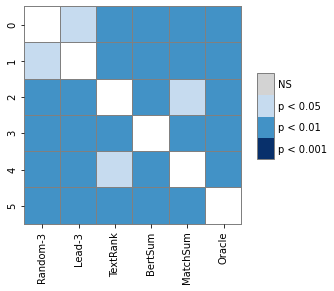


ROUGE-2


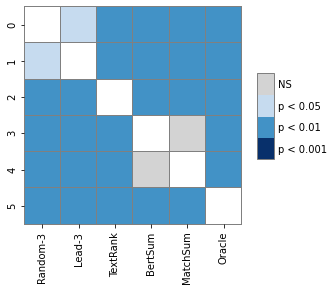


ROUGE-L


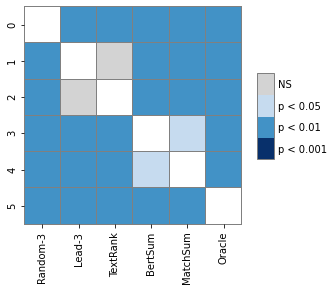


BLEU


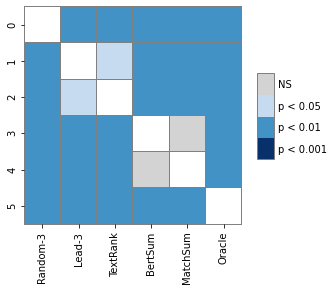


METEOR


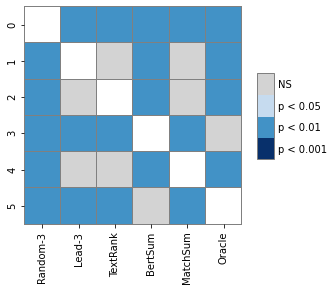


BERT-Score


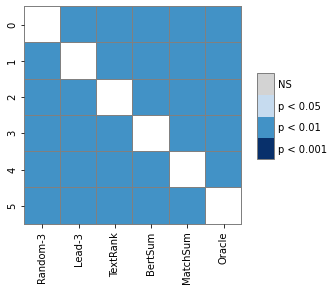


Mover-Score


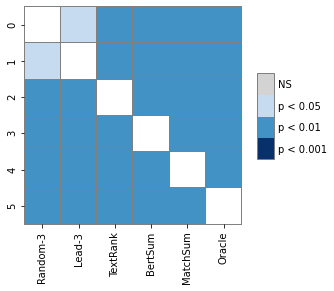


BLANC


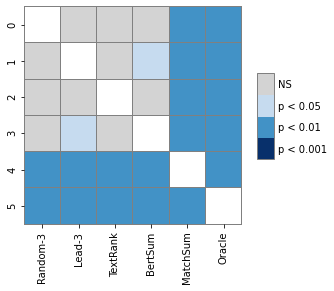


JS


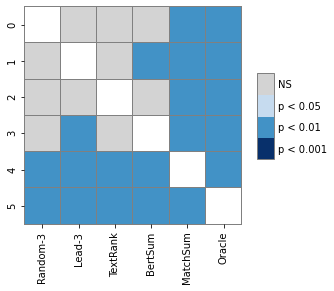

Random-3    Lead-3  TextRank   BertSum  MatchSum  Oracle
0  1.000000  0.452756  0.900000  0.518356     0.001   0.001
1  0.452756  1.000000  0.900000  0.005403     0.001   0.001
2  0.900000  0.900000  1.000000  0.082528     0.001   0.001
3  0.518356  0.005403  0.082528  1.000000     0.001   0.001
4  0.001000  0.001000  0.001000  0.001000     1.000   0.001
5  0.001000  0.001000  0.001000  0.001000     0.001   1.000

In [ ]:
print("\n" + evaluation_methods[0])
posthoc_nemenyi_friedman(rouge1_eval, summarization_methods)

print("\n" + evaluation_methods[1])
posthoc_nemenyi_friedman(rouge2_eval, summarization_methods)

print("\n" + evaluation_methods[2])
posthoc_nemenyi_friedman(rougel_eval, summarization_methods)

print("\n" + evaluation_methods[3])
posthoc_nemenyi_friedman(bleu_eval, summarization_methods)

print("\n" + evaluation_methods[4])
posthoc_nemenyi_friedman(meteor_eval, summarization_methods)

print("\n" + evaluation_methods[5])
posthoc_nemenyi_friedman(bert_score_eval, summarization_methods)

print("\n" + evaluation_methods[6])
posthoc_nemenyi_friedman(mover_score_eval, summarization_methods)

print("\n" + evaluation_methods[7])
posthoc_nemenyi_friedman(blanc_eval, summarization_methods)

print("\n" + evaluation_methods[8])
posthoc_nemenyi_friedman(js_eval, summarization_methods)

## Human Evaluation

In [ ]:
print("\n" + human_eval_methods[0])
one_way_r_anova(ovq_eval, human_summ_methods)
friedman(ovq_eval, human_summ_methods)

print("\n" + human_eval_methods[1])
one_way_r_anova(coherence_eval, human_summ_methods)
friedman(coherence_eval, human_summ_methods)

print("\n" + human_eval_methods[2])
one_way_r_anova(readibility_eval, human_summ_methods)
friedman(readibility_eval, human_summ_methods)

print("\n" + human_eval_methods[3])
one_way_r_anova(fluency_eval, human_summ_methods)
friedman(fluency_eval, human_summ_methods)

print("\n" + human_eval_methods[4])
one_way_r_anova(inf_eval, human_summ_methods)
friedman(inf_eval, human_summ_methods)


Overall Quality
ONE WAY REPEATED ANOVA: Statistics=3.38134, p=0.02424
Significant difference between:
['TextRank', 'BertSum', 'MatchSum', 'Expert']

Mean of TextRank is: 3.37 and sd is: 0.744
Mean of BertSum is: 3.44 and sd is: 0.631
Mean of MatchSum is: 3.85 and sd is: 0.701
Mean of Expert is: 3.84 and sd is: 0.578
Please use repeated t-Test or anova, both features are normal distributed.

Coherence
ONE WAY REPEATED ANOVA: Statistics=2.41739, p=0.07564
NO significant difference between:
['TextRank', 'BertSum', 'MatchSum', 'Expert']
Please use repeated t-Test or anova, both features are normal distributed.

Readability
Not all distributions are normal, please use Friedmans test
FRIEDMAN TEST: Statistics=23.460674, p=0.000032
Significant difference between:
['TextRank', 'BertSum', 'MatchSum', 'Expert']

Mean of TextRank is: 3.68 and sd is: 0.588
Mean of BertSum is: 3.77 and sd is: 0.581
Mean of MatchSum is: 4.22 and sd is: 0.569
Mean of Expert is: 4.33 and sd is: 0.483

Fluency
Not all

(6.781249999999991, 0.07920674444534782, False)


Overall Quality


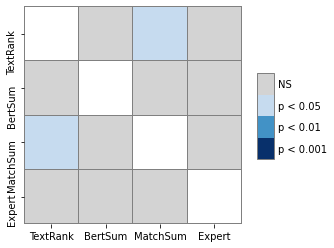


Coherence


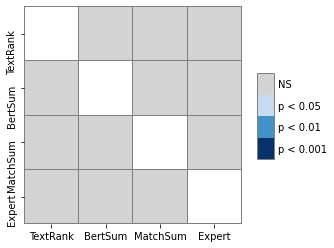

TextRank   BertSum  MatchSum    Expert
TextRank  1.000000  0.864333  0.221192  0.080184
BertSum   0.864333  1.000000  0.163249  0.054797
MatchSum  0.221192  0.163249  1.000000  0.598713
Expert    0.080184  0.054797  0.598713  1.000000

In [ ]:
print("\n" + human_eval_methods[0])
posthoc_dunn(ovq_eval, human_summ_methods)

print("\n" + human_eval_methods[1])
posthoc_dunn(coherence_eval, human_summ_methods)


Readability


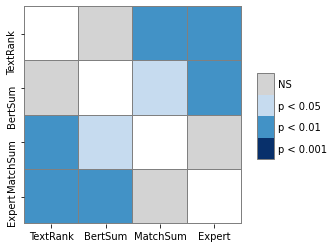


Fluency


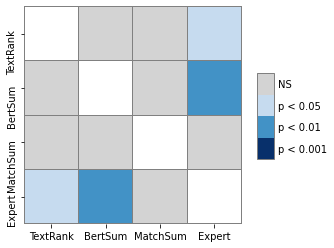


Informativeness


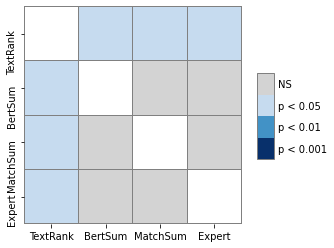

TextRank   BertSum  MatchSum    Expert
TextRank  1.000000  0.017389  0.038695  0.042028
BertSum   0.017389  1.000000  0.755826  0.729990
MatchSum  0.038695  0.755826  1.000000  0.972740
Expert    0.042028  0.729990  0.972740  1.000000

In [ ]:
print("\n" + human_eval_methods[2])
posthoc_dunn(readibility_eval, human_summ_methods)

print("\n" + human_eval_methods[3])
posthoc_dunn(fluency_eval, human_summ_methods)

print("\n" + human_eval_methods[4])
posthoc_dunn(inf_eval, human_summ_methods)

In [ ]:
print("\n" + human_eval_methods[0])
mann_whitney(ovq_eval, ovq_eval, "Expert", "TextRank")
mann_whitney(ovq_eval, ovq_eval, "Expert", "BertSum")
mann_whitney(ovq_eval, ovq_eval, "Expert", "MatchSum")

print("\n" + human_eval_methods[1])
mann_whitney(coherence_eval, coherence_eval, "Expert", "TextRank")
mann_whitney(coherence_eval, coherence_eval, "Expert", "BertSum")
mann_whitney(coherence_eval, coherence_eval, "Expert", "MatchSum")

print("\n" + human_eval_methods[2])
mann_whitney(readibility_eval, readibility_eval, "Expert", "TextRank")
mann_whitney(readibility_eval, readibility_eval, "Expert", "BertSum")
mann_whitney(readibility_eval, readibility_eval, "Expert", "MatchSum")

print("\n" + human_eval_methods[3])
mann_whitney(fluency_eval, fluency_eval, "Expert", "TextRank")
mann_whitney(fluency_eval, fluency_eval, "Expert", "BertSum")
mann_whitney(fluency_eval, fluency_eval, "Expert", "MatchSum")

print("\n" + human_eval_methods[4])
mann_whitney(inf_eval, inf_eval, "Expert", "TextRank")
mann_whitney(inf_eval, inf_eval, "Expert", "BertSum")
mann_whitney(inf_eval, inf_eval, "Expert", "MatchSum")


Overall Quality

MANN-WHITNEY U TEST: Statistics=276.500, p=0.039
Significant difference between Expert and TextRank
Mean of Expert is: 3.8400000000000007
Mean of TextRank is: 3.37

MANN-WHITNEY U TEST: Statistics=268.000, p=0.066
NO significant difference between Expert and BertSum
Mean of Expert is: 3.8400000000000007
Mean of BertSum is: 3.44

MANN-WHITNEY U TEST: Statistics=193.000, p=0.860
NO significant difference between Expert and MatchSum
Mean of Expert is: 3.8400000000000007
Mean of MatchSum is: 3.85

Coherence

MANN-WHITNEY U TEST: Statistics=268.000, p=0.066
NO significant difference between Expert and TextRank
Mean of Expert is: 3.650000000000001
Mean of TextRank is: 3.250000000000001

MANN-WHITNEY U TEST: Statistics=275.500, p=0.042
Significant difference between Expert and BertSum
Mean of Expert is: 3.650000000000001
Mean of BertSum is: 3.2299999999999995

MANN-WHITNEY U TEST: Statistics=210.000, p=0.796
NO significant difference between Expert and MatchSum
Mean of Exper

(195.0, 0.9026427711549115, False)

In [ ]:
col_names = ["Machine", "Crowd",'Correlation Type', 'Correlation', 'Significance']
create_correlation_table(human_machine_eval, human_machine_eval, evaluation_methods, human_eval_methods, "Spearman", col_names)

Machine            Crowd Correlation Type Correlation Significance
0      ROUGE-1  Overall Quality         Spearman       0.189        0.149
1      ROUGE-1        Coherence         Spearman       0.193         0.14
2      ROUGE-1      Readability         Spearman       0.183        0.162
3      ROUGE-1          Fluency         Spearman       0.152        0.246
4      ROUGE-1  Informativeness         Spearman       0.269        0.037
0      ROUGE-2  Overall Quality         Spearman      -0.013        0.921
1      ROUGE-2        Coherence         Spearman      -0.015        0.911
2      ROUGE-2      Readability         Spearman       0.001        0.992
3      ROUGE-2          Fluency         Spearman       -0.05        0.704
4      ROUGE-2  Informativeness         Spearman       0.018         0.89
0      ROUGE-L  Overall Quality         Spearman       0.079        0.548
1      ROUGE-L        Coherence         Spearman       0.086        0.516
2      ROUGE-L      Readability         Spearman       0.116        0.379
3      ROUGE-L          Fluency         Spearman       0.054        0.681
4      ROUGE-L  Informativeness         Spearman       0.192        0.141
0         BLEU  Overall Quality         Spearman       0.202        0.122
1         BLEU        Coherence         Spearman       0.229        0.078
2         BLEU      Readability         Spearman       0.249        0.055
3         BLEU          Fluency         Spearman       0.236        0.069
4         BLEU  Informativeness         Spearman       0.284        0.028
0       METEOR  Overall Quality         Spearman       0.174        0.183
1       METEOR        Coherence         Spearman       0.192        0.143
2       METEOR      Readability         Spearman         0.1        0.449
3       METEOR          Fluency         Spearman       0.173        0.185
4       METEOR  Informativeness         Spearman       0.282        0.029
0   BERT-Score  Overall Quality         Spearman       0.229        0.079
1   BERT-Score        Coherence         Spearman       0.242        0.063
2   BERT-Score      Readability         Spearman        0.24        0.064
3   BERT-Score          Fluency         Spearman       0.205        0.116
4   BERT-Score  Informativeness         Spearman       0.295        0.022
0  Mover-Score  Overall Quality         Spearman       0.198        0.129
1  Mover-Score        Coherence         Spearman        0.23        0.078
2  Mover-Score      Readability         Spearman        0.17        0.193
3  Mover-Score          Fluency         Spearman       0.186        0.155
4  Mover-Score  Informativeness         Spearman       0.195        0.135
0        BLANC  Overall Quality         Spearman      -0.112        0.396
1        BLANC        Coherence         Spearman      -0.091        0.491
2        BLANC      Readability         Spearman      -0.267        0.039
3        BLANC          Fluency         Spearman      -0.183        0.162
4        BLANC  Informativeness         Spearman      -0.039        0.766
0           JS  Overall Quality         Spearman      -0.017        0.899
1           JS        Coherence         Spearman       0.038        0.774
2           JS      Readability         Spearman        0.23        0.077
3           JS          Fluency         Spearman       0.085        0.519
4           JS  Informativeness         Spearman      -0.226        0.082

In [33]:
col_names = ["Quality Estimation", "Crowd", 'Correlation Type', 'Correlation', 'Significance']
create_correlation_table(human_machine_eval, human_machine_eval, qe_methods, human_eval_methods, "Spearman", col_names)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Quality Estimation            Crowd  ... Correlation Significance
0    expert_coherence  Overall Quality  ...       0.169        0.196
1    expert_coherence        Coherence  ...       0.203         0.12
2    expert_coherence      Readability  ...        0.21        0.107
3    expert_coherence          Fluency  ...       0.295        0.022
4    expert_coherence  Informativeness  ...       0.076        0.562
0      expert_fluency  Overall Quality  ...         NaN          NaN
1      expert_fluency        Coherence  ...         NaN          NaN
2      expert_fluency      Readability  ...         NaN          NaN
3      expert_fluency          Fluency  ...         NaN          NaN
4      expert_fluency  Informativeness  ...         NaN          NaN
0    expert_relevance  Overall Quality  ...       0.007        0.958
1    expert_relevance        Coherence  ...       0.028        0.832
2    expert_relevance      Readability  ...      -0.257        0.047
3    expert_relevance          Fluency  ...      -0.112        0.395
4    expert_relevance  Informativeness  ...      -0.035        0.791
0  expert_consistency  Overall Quality  ...         NaN          NaN
1  expert_consistency        Coherence  ...         NaN          NaN
2  expert_consistency      Readability  ...         NaN          NaN
3  expert_consistency          Fluency  ...         NaN          NaN
4  expert_consistency  Informativeness  ...         NaN          NaN
0     crowd_coherence  Overall Quality  ...       0.061        0.641
1     crowd_coherence        Coherence  ...       0.058        0.659
2     crowd_coherence      Readability  ...      -0.059        0.653
3     crowd_coherence          Fluency  ...       0.011        0.933
4     crowd_coherence  Informativeness  ...       0.222        0.088
0       crowd_fluency  Overall Quality  ...       0.153        0.244
1       crowd_fluency        Coherence  ...       0.128        0.328
2       crowd_fluency      Readability  ...       0.138        0.292
3       crowd_fluency          Fluency  ...       0.145        0.269
4       crowd_fluency  Informativeness  ...       0.111        0.399
0     crowd_relevance  Overall Quality  ...       0.266         0.04
1     crowd_relevance        Coherence  ...       0.271        0.036
2     crowd_relevance      Readability  ...      -0.029        0.827
3     crowd_relevance          Fluency  ...       0.135        0.303
4     crowd_relevance  Informativeness  ...       0.118        0.371
0   crowd_consistency  Overall Quality  ...      -0.023        0.863
1   crowd_consistency        Coherence  ...       0.005         0.97
2   crowd_consistency      Readability  ...      -0.014        0.917
3   crowd_consistency          Fluency  ...        0.01         0.94
4   crowd_consistency  Informativeness  ...       0.003        0.982

[40 rows x 5 columns]